Objective:
Evaluate alternative trading strategies to improve asset profitability relative to the client’s legacy approach, and identify a recommended operating model.

In [10]:
# --- Recreate legacy (client) strategy for comparison ---

import numpy as np

price_series = prices["price"].values
T = len(price_series)

capacity = 2.0
max_power = 1.0
efficiency = 0.9
dt = 1.0

state_of_charge = 0.0
legacy_profit = []
legacy_soc = []

median_price = np.median(price_series)

for t in range(T):
    price = price_series[t]

    if price < median_price and state_of_charge < capacity:
        energy = min(max_power * dt, capacity - state_of_charge)
        state_of_charge += energy * efficiency
        legacy_profit.append(-energy * price)

    elif price > median_price and state_of_charge > 0:
        energy = min(max_power * dt, state_of_charge)
        state_of_charge -= energy
        legacy_profit.append(energy * price)

    else:
        legacy_profit.append(0)

    legacy_soc.append(state_of_charge)

legacy = prices.copy()
legacy["profit"] = legacy_profit
legacy["cumulative_profit"] = legacy["profit"].cumsum()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

prices = pd.read_csv("../data/raw/prices.csv")
prices["datetime"] = pd.to_datetime(prices["datetime"])
prices = prices.set_index("datetime")

capacity = 2.0
max_power = 1.0
dt = 1.0

p = prices["price"]

cheapest = p.nsmallest(int(capacity / (max_power*dt))).index
priciest = p.nlargest(int(capacity / (max_power*dt))).index

bench = prices.copy()
bench["charge_MWh"] = 0.0
bench["discharge_MWh"] = 0.0

bench.loc[cheapest, "charge_MWh"] = max_power * dt
bench.loc[priciest, "discharge_MWh"] = max_power * dt

bench["profit"] = bench["price"] * (bench["discharge_MWh"] - bench["charge_MWh"])
bench["cumulative_profit"] = bench["profit"].cumsum()

bench["profit"].sum()


np.float64(103.0)

This is strategy A. it assumes we had perfect foresight and im using it as a bench mark. This isnt to say this is realistic but to answer is this asset fundamentally capable of adding value.

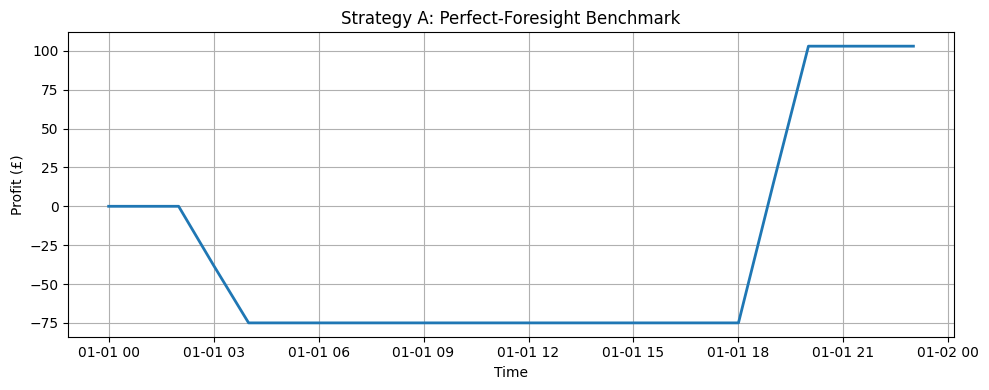

In [2]:
plt.figure(figsize=(10,4))
plt.plot(bench.index, bench["cumulative_profit"], linewidth=2)
plt.title("Strategy A: Perfect-Foresight Benchmark")
plt.ylabel("Profit (£)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


With perfect information, the asset is capable of generating positive value, establishing an upper bound on achievable profitability.

Strategy B - something that is client viable

In [4]:
import cvxpy as cp

p = prices["price"].values
T = len(p)

capacity = 2.0
max_power = 1.0
eff = 0.9
dt = 1.0

charge = cp.Variable(T, nonneg=True)
discharge = cp.Variable(T, nonneg=True)
soc = cp.Variable(T+1)

constraints = [
    soc[0] == 0,
    soc >= 0,
    soc <= capacity,
    charge <= max_power * dt,
    discharge <= max_power * dt,
]

for t in range(T):
    constraints += [
        soc[t+1] == soc[t] + eff*charge[t] - discharge[t]
    ]

constraints += [soc[T] == 0]

objective = cp.Maximize(cp.sum(cp.multiply(p, discharge - charge)))
prob = cp.Problem(objective, constraints)
prob.solve()

opt = prices.copy()
opt["profit"] = p * (discharge.value - charge.value)
opt["cumulative_profit"] = opt["profit"].cumsum()

opt["profit"].sum()


np.float64(120.55555548182488)

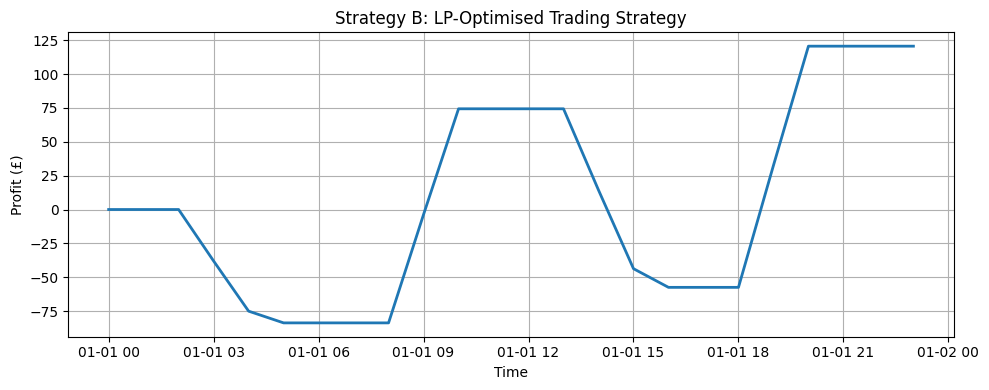

In [5]:
plt.figure(figsize=(10,4))
plt.plot(opt.index, opt["cumulative_profit"], linewidth=2)
plt.title("Strategy B: LP-Optimised Trading Strategy")
plt.ylabel("Profit (£)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


The optimised strategy captures a significant portion of the theoretical upper bound while respecting operational constraints, delivering materially higher profitability than the client’s legacy approach.

/var/folders/rr/jh9q1ytn4952nqgsmw29wtmr0000gn/T/ipykernel_30707/2142644338.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


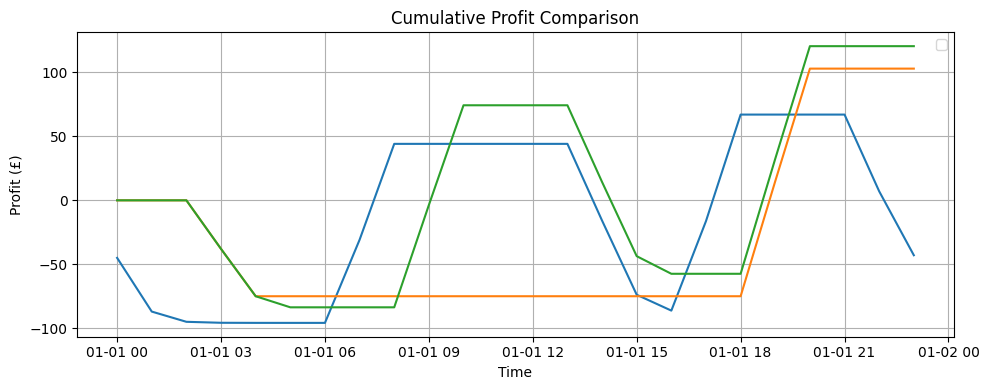

In [12]:
comparison = pd.DataFrame(index=prices.index)

comparison["Legacy strategy"] = legacy["cumulative_profit"]
comparison["Benchmark (upper bound)"] = bench["cumulative_profit"]
comparison["Optimised strategy"] = opt["cumulative_profit"]


import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(comparison.index, comparison)
plt.title("Cumulative Profit Comparison")
plt.ylabel("Profit (£)")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

